## Import libraries

In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import rasterio.plot as rplt

## Load the dataset

First we load the excel table as a pandas DataFrame and drop rows with NaN's. Next, we will clean the data from non-numeric values (some of the coordinates are not-valid), and then we need to convert it into GeoDataFrame.  After, we will change the coordinate system to EPSG:4243 which includes India's mainland

In [2]:
ground_water = pd.read_excel('**Path**/GWQ 2000-2018.xlsx').dropna(axis=0)
ground_water = ground_water[ground_water.LONGITUDE.apply(lambda x: type(x) in [int, np.int64, float, np.float64])]
ground_water = ground_water[ground_water.LATITUDE.apply(lambda x: type(x) in [int, np.int64, float, np.float64])]
ground_water = gpd.GeoDataFrame(ground_water[['LONGITUDE','LATITUDE']], geometry=gpd.points_from_xy(ground_water['LONGITUDE'], ground_water['LATITUDE']))
ground_water.set_crs('EPSG:4243', inplace=True);
ground_water

,LONGITUDE,LATITUDE,geometry
0,92.955278,13.230833,POINT (92.95528 13.23083)
1,92.955278,13.230833,POINT (92.95528 13.23083)
2,92.955278,13.230833,POINT (92.95528 13.23083)
3,93.003056,13.285556,POINT (93.00306 13.28556)
4,93.003056,13.285556,POINT (93.00306 13.28556)
...,...,...,...
151112,87.33,22.51,POINT (87.33000 22.51000)
151113,87.16,22.18,POINT (87.16000 22.18000)
151114,87.52,22.58,POINT (87.52000 22.58000)
151115,87.02,22.47,POINT (87.02000 22.47000)


### Loading India's country Shapfile

The next cell will load the India country boundary, and will also set it's CRS to be same as the ground water data (EPSG:4243)

<AxesSubplot:>

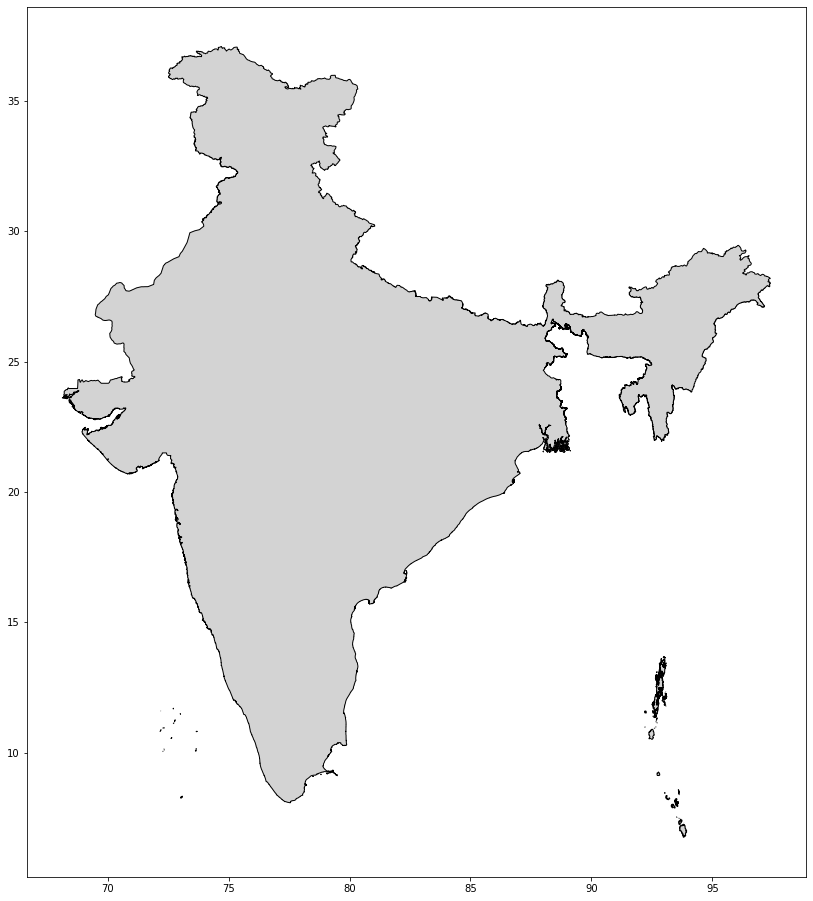

In [3]:
india_boundary = gpd.read_file('**Path**/India_Country_Boundary.shp')
india_boundary.to_crs('EPSG:4243', inplace=True)
fig, ax = plt.subplots(figsize=(16,16))
india_boundary.plot(ax=ax, color='lightgrey', ec='k')

## Screen out of bound data

Let's plot the points to see how they look on a map:

<AxesSubplot:>

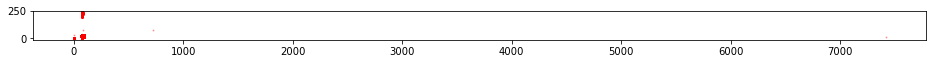

In [4]:
fig, ax = plt.subplots(figsize=(16,16))
india_boundary.plot(ax=ax, color='lightgrey', ec='k')
ground_water.plot(aspect=1, ax=ax, color='r', markersize=1, alpha=0.3)

As it can be seen from both axis - we have points with wrong coordinates. If it was a small dataset, I would try to find out which ones are wrong and correct them, but in this case we will filter all data points that are outside of the boundary of India, as in the next steps they won't get any real data added to them from the rasters. These points probably had a mistake when they were recorded.

<AxesSubplot:>

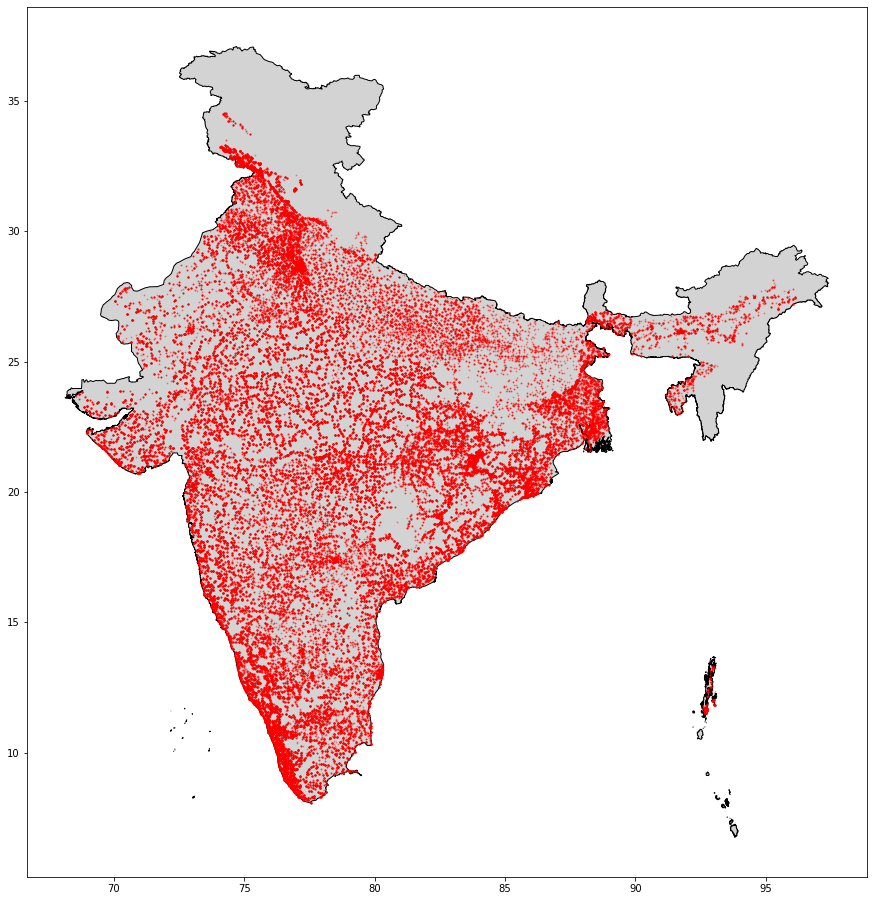

In [5]:
ground_water_india = gpd.sjoin(ground_water, india_boundary, how="inner", op="within")
ground_water_india.drop(['index_right', 'Area'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(16,16))
india_boundary.plot(ax=ax, color='lightgrey', ec='k')
ground_water_india.plot(aspect=1, ax=ax, color='r', markersize=1, alpha=0.3)

## Global Raster

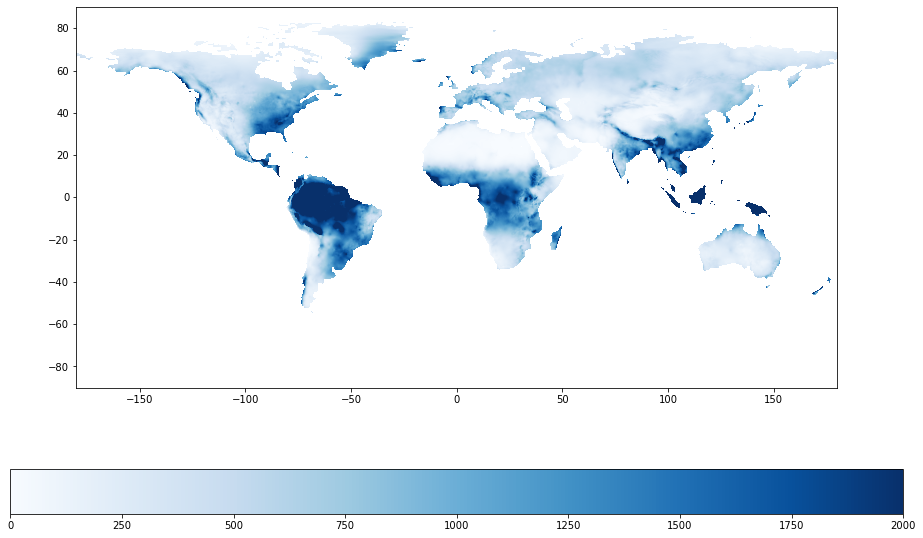

In [9]:
from PIL import Image  
Image.MAX_IMAGE_PIXELS = None
from matplotlib import cm
import rasterio as rio
import rasterio.plot as rplt

fig, ax = plt.subplots(figsize=(16,10))
cmap= cm.get_cmap('Blues').copy() #.reversed()
cmap.set_under('w')
f = rio.open('**Path**/Precipitation 2018.tif')
retted = rplt.show(f, ax=ax, cmap=cmap, vmin=0, vmax=2000)

im = retted.get_images()[0]
fig.colorbar(im, ax=ax, orientation="horizontal")
#plt.show()
plt.savefig('**Path**/Precipitation 2018.png', dpi=300)

Next, we will build a function that clips the raster with India's boundaries. 
As the mask.mask function returns all 'nodata' pixels as 0, it will make it impossible to distinguish between nodata pixels and pixles that truely hold a value of 0, it will also affect the plots in the next step. So we will replace it to be a negative 256.

In addition, we will also save the clipped raster into a new folder.

In [6]:
yearly_precipitaion_2018_global = '**Path**/Precipitation 2018.tif'

from rasterio import mask
import numpy as np
from shapely.geometry import mapping

def clip_raster(name, link, gdf):
    img = rio.open(link, crs='EPSG:4243')
    clipped_array, clipped_transform = mask.mask(img, gdf, crop=True, nodata=-256)
    out_meta = img.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": clipped_array.shape[1],
                 "width": clipped_array.shape[2],
                 "transform": clipped_transform})
    with rio.open('**Path**/' + str(name) + '.tif', "w", **out_meta) as dest:
        dest.write(clipped_array)
        dest.close()
    img.close()
    
    print('Finished to clip and save ' + str(name))
    return clipped_array

In [7]:
india_boundary_un = india_boundary.unary_union
yearly_precipitaion_2018_india = clip_raster(str('Precipitation 2018'), yearly_precipitaion_2018_global, india_boundary_un)

C:\Users\Asaf\miniconda3\envs\geo_ds\lib\site-packages\rasterio\features.py:416: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, north_up=north_up) for shape in shapes]
C:\Users\Asaf\miniconda3\envs\geo_ds\lib\site-packages\rasterio\features.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


Finished to clip and save Precipitation 2018


## The result of clipping

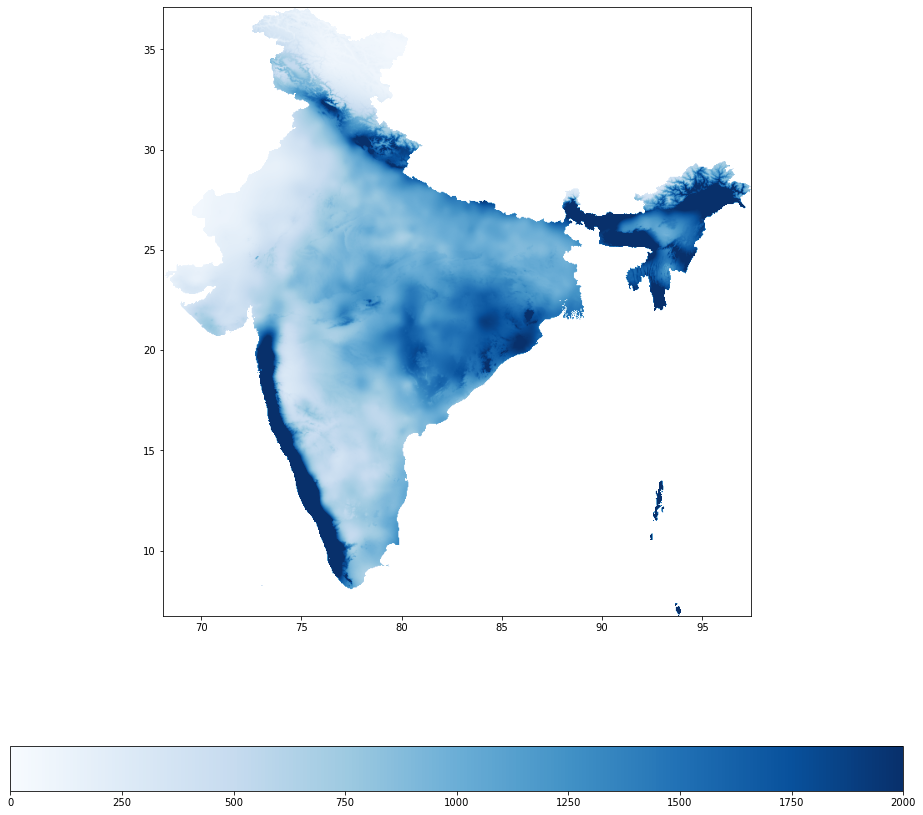

In [10]:
from PIL import Image  
Image.MAX_IMAGE_PIXELS = None
from matplotlib import cm
import rasterio as rio
import rasterio.plot as rplt

fig, ax = plt.subplots(figsize=(16,16))
cmap= cm.get_cmap('Blues').copy() #.reversed()
cmap.set_under('w')
f = rio.open('**Path**.tif')
retted = rplt.show(f, ax=ax, cmap=cmap, vmin=0, vmax=2000)

im = retted.get_images()[0]
fig.colorbar(im, ax=ax, orientation="horizontal")
#plt.show()
plt.savefig('**Path**/India Precipitation 2018.png', dpi=300)

## Data's spatial joining

Last step. We will join the data for each data point from all the rasters and shapfiles, so each point will hold it's data based on the coordinates. For that, we need to make sure that we are using the same coordinate reference system (CRS) for all maps. We are using EPSG:7755 which is India's coordinate system

In [8]:
import os
import glob

path = '**Path**'

coord_list = [(x,y) for x,y in zip(ground_water_india['geometry'].x , ground_water_india['geometry'].y)]
for filename in glob.glob(os.path.join(path, '*.tif')):
    with rio.open(os.path.join(os.getcwd(), filename)) as f: 
        ground_water_india[str(filename.split('\\')[-1][:-4])] = [sample[0] for sample in f.sample(coord_list)]
        print('Finished adding ' + filename.split('\\')[-1][:-4])

Finished adding Precipitation 2018


,LONGITUDE,LATITUDE,geometry,Precipitation 2018
0,92.955278,13.230833,POINT (92.95528 13.23083),3329.554196
1,92.955278,13.230833,POINT (92.95528 13.23083),3329.554196
2,92.955278,13.230833,POINT (92.95528 13.23083),3329.554196
3,93.003056,13.285556,POINT (93.00306 13.28556),NaN
4,93.003056,13.285556,POINT (93.00306 13.28556),NaN
...,...,...,...,...
150900,88.1125,21.700833,POINT (88.11250 21.70083),1536.227213
150901,88.073868,21.648267,POINT (88.07387 21.64827),1517.491221
150637,88.1125,21.700833,POINT (88.11250 21.70083),1536.227213
150900,88.1125,21.700833,POINT (88.11250 21.70083),1536.227213
